# EDSA Movie Recommendation Challenge

# Introduction

## Context

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

## Problem Statement
With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## Evaluation
The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process.

# Data Exploration

## Installing and Importing packages


In [ ]:
# !pip install turicreate

In [2]:
import pandas as pd
import numpy as np
import re

# import turicreate

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Overview
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

### Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

### Supplied Files

1. genome_scores.csv - a score mapping the strength between movies and tag-related properties.
2. genome_tags.csv - user assigned tags for genome-related scores
3. imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
4. movies.csv - consists of userId,movieId,tag and timestamp
5. links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
6. tags.csv - User assigned for the movies within the dataset.
7. test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
8. train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

### Loading data files

In [4]:
train_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/train.csv', usecols = ['userId', 'movieId', 'rating'])
test_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/test.csv')
imdb_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/imdb_data.csv')
movies_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/movies.csv')
tags = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/tags.csv')
genome_tags = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/genome_tags.csv')
genome_scores = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/genome_scores.csv')

In [5]:
def getTableAttributes(df, df_name):
    rows, columns = df.shape
    print(f"{df_name} consists of {rows} rows and {columns} columns \n")

    for column in df.columns.tolist():
        print(f"Column '{column}' has {df[column].nunique()} unique values")

    print(' ')
    return df.head(3)

In [ ]:
getTableAttributes(df = train_data, df_name = 'train_data')

train_data consists of 10000038 rows and 3 columns 

Column 'userId' has 162541 unique values
Column 'movieId' has 48213 unique values
Column 'rating' has 10 unique values
 


,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0


Train data consists of 3 columns (userId, movieId and rating). We dropped the timestamp when we loaded the data. We have 10 million rows in total.

In [ ]:
getTableAttributes(df = imdb_data, df_name = 'imdb_data')

imdb_data consists of 27278 rows and 6 columns 

Column 'movieId' has 27278 unique values
Column 'title_cast' has 17143 unique values
Column 'director' has 11786 unique values
Column 'runtime' has 274 unique values
Column 'budget' has 1362 unique values
Column 'plot_keywords' has 16008 unique values
 


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry


Imdb_data has 5 columns besides the movieId, i.e title_cast, movie director, plot key words, runtime and budget. Has 27278 movieIds, much less than we have in the training data.

In [ ]:
getTableAttributes(df = movies_data, df_name = 'movies_data')

movies_data consists of 62423 rows and 3 columns 

Column 'movieId' has 62423 unique values
Column 'title' has 62325 unique values
Column 'genres' has 1639 unique values
 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Movies_data contains a movie's actual title as well as the movie genre. 62423 movies in total indicating that some of the movies in the table are not in train_data.

In [ ]:
getTableAttributes(df = tags, df_name = 'tags')

tags consists of 1093360 rows and 4 columns 

Column 'userId' has 14592 unique values
Column 'movieId' has 45251 unique values
Column 'tag' has 73050 unique values
Column 'timestamp' has 907730 unique values
 


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598


In [ ]:
getTableAttributes(df = genome_tags, df_name = 'genome_tags')

genome_tags consists of 1128 rows and 2 columns 

Column 'tagId' has 1128 unique values
Column 'tag' has 1128 unique values
 


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [ ]:
getTableAttributes(df = genome_scores, df_name = 'genome_scores')

genome_scores consists of 15584448 rows and 3 columns 

Column 'movieId' has 13816 unique values
Column 'tagId' has 1128 unique values
Column 'relevance' has 4000 unique values
 


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250


###### task: merge tables
Below we utilise a pandas function that joins 2 data tables thus the function takes as argument 2 dataframes, joins them by a column. Note that the joining operation can be done on columns such as userId or movieId. First we'll merge imdb_data and movies_data as these tables contain information thats directly related to each other by movieId. We call the new table items_data, referencing movies as items. Note also that we do an outer join. This is so we can preserve all movieIds. Later we'll drop movieIds that are not available in the training data. The resulting table will have 64835 movies in total and 6 columns as displayed below.

In [ ]:
items_data = pd.merge(
    left = imdb_data,
    right = movies_data,
    on = ['movieId'],
    how = 'outer'
)

getTableAttributes(df = items_data, df_name = 'items_data')

items_data consists of 64835 rows and 8 columns 

Column 'movieId' has 64835 unique values
Column 'title_cast' has 17143 unique values
Column 'director' has 11786 unique values
Column 'runtime' has 274 unique values
Column 'budget' has 1362 unique values
Column 'plot_keywords' has 16008 unique values
Column 'title' has 62325 unique values
Column 'genres' has 1639 unique values
 


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance


The next step is to drop movie items in items_data that are not available in train_data. To determine if a movie item is present in train_data, we'll do yet another merge operation. This time we merge the table items_data with only the movieId column of train_data. This we do for computational and storage reasons as the merge will result in many duplicate rows for each userId in train_data. We'll also set the how parameter of the merge function to left to prioritise observation in train_data and drop those that are not. Further, instead of immediately storing the merged table, we'll first drop duplicates in it so that we dont have duplicated information about movie items. 

In [ ]:
items_data = pd.merge(left = train_data[['movieId']], right = items_data, ).drop_duplicates()
getTableAttributes(df = items_data, df_name = 'items_data')

items_data consists of 48213 rows and 8 columns 

Column 'movieId' has 48213 unique values
Column 'title_cast' has 14531 unique values
Column 'director' has 9995 unique values
Column 'runtime' has 257 unique values
Column 'budget' has 1222 unique values
Column 'plot_keywords' has 13791 unique values
Column 'title' has 48151 unique values
Column 'genres' has 1558 unique values
 


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


The result is items_data with only 48213 rows and 8 columns. Does train_data have 48213 movieIds? Lets check.

In [ ]:
train_data['movieId'].nunique()

48213

###### task: investigate missing entries

In [ ]:
train_data.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

train_data has zero missing entires.

In [ ]:
missingness_data = items_data.isna().sum() / items_data.shape[0]
for column in missingness_data.index:
    print(f"Column {column:{15}}{round(missingness_data[column] * 100, 2):{10}}%")

Column movieId               0.0%
Column title_cast          69.78%
Column director            69.54%
Column runtime             72.99%
Column budget              85.21%
Column plot_keywords       71.16%
Column title                 0.0%
Column genres                0.0%


items_data has a significant amount of missing entries, between 69% and 85% across the columns. Mostly missing are the movie budgets. This indicates that we ought to be careful interms of the conclusions we draw from this movie contents table. To be able to analyse the textual data in these columns however, we need to treat them. Similarly, for the budget and runtime columns. How do we treat them? ...

In [ ]:
# items_data.fillna(' ', inplace = True)

###### task: cleaning up the text data
In this task we take the opportunity to do further cleaning of the text content of movie items. How do we clean the text? ...

In [ ]:
items_data.head(3)

,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


In [ ]:
# text_corpus = [row[2].replace(' ', '_').replace('|', ' ') + ' ' + row[3].replace('|', ' ') + ' ' + row[4].replace(' ', '_').replace('|', ' ') + ' ' + row[6].replace(' ', '_').replace('|', ' ') for row in item_data.itertuples()]

In [ ]:
# item_data['text'] = pd.Series(text_corpus)

# del text_corpus, imdb_data, movies_data
# item_data.drop(['title_cast', 'director', 'plot_keywords', 'title', 'genres'], axis = 1, inplace = True)

# item_data.head(3)

In [ ]:
# def cleanText(text):
#     new_text = text.replace('_', '')
#     return new_text

# item_data['text'] = item_data['text'].map(cleanText)

# item_data.head(3)

# Exploratory Data Analysis
As we have noticed, we have a significant number of users and movies in the data set, 48213 and 162541 respectively. This results in a little over 10 million rows of training data if the data is in tidy format i.e each row represents a user-movie combination. However, to analyse the data through use of machine learning techniques we will have to spread the dataset such that each row represents a single user and each column a single movie item or vise versa. Note that in this format the cells should contain ratings. This will then result in a highly sparse matrix as users generally do not provide a rating for a movie they have not watched. This will be a very large matrix and hard to process with small RAM computers.

These concerns motivate most of what we cover in this section. The first part of EDA will be devoted to:
- understanding the basic structure of the ratings. we ask questions such as: which are the most rated/watched movies, which users tend to watch a lot or the least number of movies and what ratings do the provide?
- understand the additional movie specific information such as the cast, directors etc. We'll make an attempt to identify movie items that can be grouped together and analyse the ratings per group.

while the second part will get into more advanced data analysis techniques such as Principal Components Analysis and clustering methods with the aim of reducing the dimensionality of the data and make it more ammenable to human understanding.

## EDA Part 1

### Ratings

###### task: analyse the ratings 
Lets start with the ratings. We start of by visualising a distribution of the ratings as they appear in the entire training data. The ratings are on a scale of 0.5 to 5. The figure below shows that the most common rating is 4. The least common is 0.5. It seems like high ratings are common indicating that perhaps users generally tend to like the movies they watch. If there is a current recommendation system, it's already doing a satisfactory job.

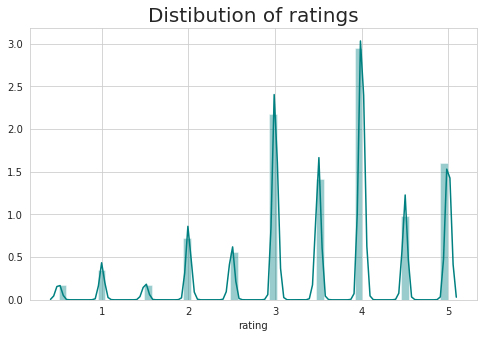

In [ ]:
plt.figure(figsize = (8, 5))
g = sns.distplot(train_data['rating'], color = 'teal')
g.set_title('Distibution of ratings', fontsize = 20)
plt.show()

Now. Are there users who watch a lot more movies than others. Look at the output below. Looks like user with ID 72315 has watched and rated nearly 13000 movies of the approx 48000 available in the data. Thats significant, especially considering he/she is seconded by a user wiyh 3680 in their list. Out of curiosity lets just take a look at what our top user rates his/her movies.

In [ ]:
num_of_movies_watched = train_data.groupby('userId')['movieId'].count().sort_values(ascending = False)
num_of_movies_watched

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
          ...  
55362         1
121071        1
127098        1
53640         1
105714        1
Name: movieId, Length: 162541, dtype: int64

From the figure below the top user's most common rating is 3. EWe'll just assume that any rating above 3 means he likes the movie and any below 3 he dislikes the movie. I think we can conclude that he likes more movies than he dislikes. Note that although we have extreme users like our top user, there are users who've watched as few movies as 1 in the dataset. Let's just be aware of this as we move on.

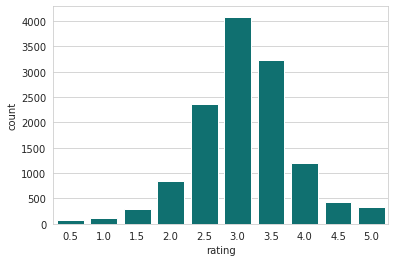

In [ ]:
top_user = num_of_movies_watched.index.tolist()[0]
top_user
top_user_ratings = train_data[train_data['userId'] == top_user]['rating']
top_user_ratings
sns.countplot(top_user_ratings, color = 'teal')

Similar to what we did above, are there movies that tend to be watched and rated by most users. Seeing the output below. There are movies that have been watched by more than 30000 users in the dataset. Thats approximately 21% of all the users. These are very popular movies. Out of curiosity we'll take the top 10 most popular movies and visualise their average rating.

In [ ]:
num_of_users_per_movie = train_data.groupby('movieId')['userId'].count().sort_values(ascending = False)
num_of_users_per_movie

movieId
318       32831
356       32383
296       31697
593       29444
2571      29014
          ...  
152731        1
152733        1
152737        1
152743        1
209171        1
Name: userId, Length: 48213, dtype: int64

Looking at the figure below, the most common rating for this group of movies is 3. Also, the movies tend to be liked more than they are disliked, which makes sense given how popular they are.

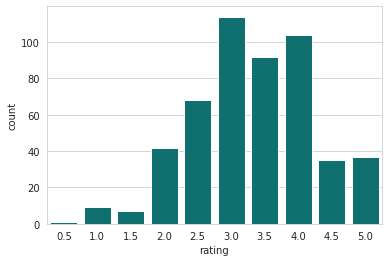

In [ ]:
ten_most_popular_movies = num_of_users_per_movie[:10].index.tolist()
data = train_data[train_data['userId'].isin(ten_most_popular_movies)]
sns.countplot(data['rating'], color = 'teal')

Looks like we're approaching a conclusion that most of the ratings tend to be concentrated around either a certain group of users i.e the top users or a certain group of movies i.e most popular movies. Let's ask a more direct question. What is the proportion of ratings accounted for by top users? Similarly, what proportion of the ratings is accounted for by the most popular movies?

###### task: analysing dimensionality
See the figure below. On the x axis we have the number of users (left) and the number of movies (right) and on the y axis we have the proportion of ratings corresponding to the number of either users and/or movies on the x axis. For example, see that if we take the most common 60000 users we already have 80% of the ratings in the database. This is even more acute for the movies i.e 10000 movies hold nearly 100% of the rating in the database. Most users do watch a lot of movies and most movies are not watched by a lot of users.

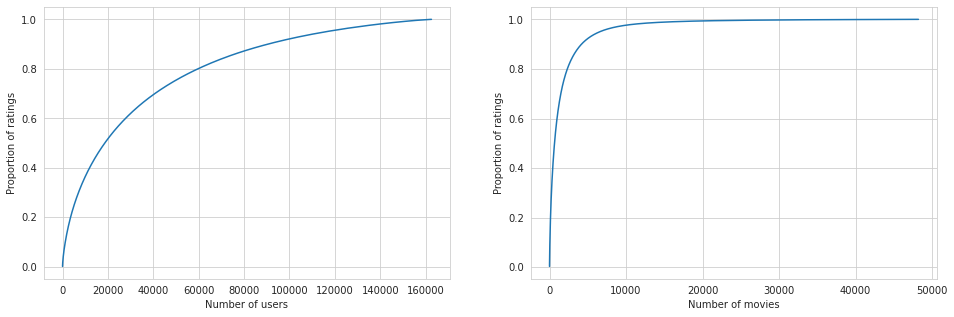

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
g = num_of_movies_watched.cumsum().div(len(train_data)).reset_index()['movieId'].plot(ax = axes[0])
# g.set_title()
g.set_xlabel('Number of users')
g.set_ylabel('Proportion of ratings')

g = num_of_users_per_movie.cumsum().div(len(train_data)).reset_index()['userId'].plot(ax = axes[1])
# g.set_title()
g.set_xlabel('Number of movies')
g.set_ylabel('Proportion of ratings')
plt.show()

Further, we find that only about 6% (9677 users) of the users have watched more than 200 movies in the database and that only 0.38% have watched less than 5 movies suggesting that users generally watch between 5 and 200 movies(84% of users).

In [ ]:
more_than_200 = num_of_movies_watched > 200
userids_w_more_than_200 = num_of_movies_watched[more_than_200].index
print(f"Only {len(userids_w_more_than_200)} users have watched more than 200 movies in the dataset.")

Only 9677 users have watched more than 200 movies in the dataset.


In [ ]:
less_than_5 = num_of_movies_watched < 5
userids_w_less_than_5 = num_of_movies_watched[less_than_5].index
print(f"{len(userids_w_less_than_5)} users have watched less than 5 movies in the dataset.")

618 users have watched less than 5 movies in the dataset.


Below we show a visual of the number of movies watched by users excluding the users with more than 200 movies in their watched list. See that the most viewership count is between 5 and 25 where we have more than 60000 users. This number ofcoarse declines as we move along the x axis. The average number of movies watched is 42.

The average number of movies watched for this group is 41.91420567598701 



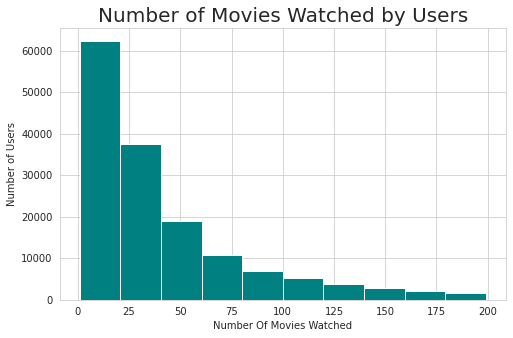

In [ ]:
fig = plt.figure(figsize = (8, 5))

less_than_200 = num_of_movies_watched < 200
data = num_of_movies_watched[less_than_200]
print(f"The average number of movies watched for this group is {data.mean()} \n")

g = data.plot(kind = 'hist', color = 'teal')
g.set_xlabel('Number Of Movies Watched')
g.set_ylabel('Number of Users')
g.set_title('Number of Movies Watched by Users', fontsize = 20)
plt.show()

Similar to above, we can visualise the count of users per movie ID in the dataset. The figure below indicates that most movies (more than 40000 of the 48000) are watched by only a few hundred users (about 300).

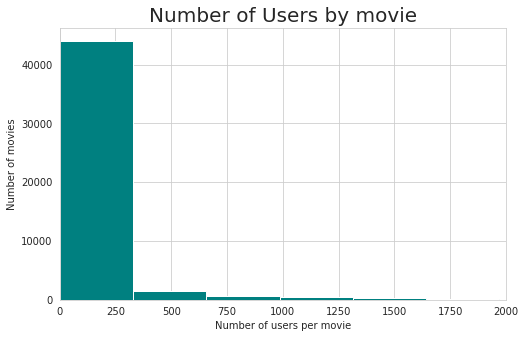

In [ ]:
fig = plt.figure(figsize = (8, 5))
g = num_of_users_per_movie.plot(kind = 'hist', bins = 100, color = 'teal')
g.set_xlim(0, 2000)
g.set_ylabel('Number of movies')
g.set_xlabel('Number of users per movie')
g.set_title('Number of Users by movie', fontsize = 20)
plt.show()

In [ ]:
n = 300
movieids_w_less_than_n = num_of_users_per_movie[num_of_users_per_movie < n].index
print(f"{len(movieids_w_less_than_n)} are watched on average by {n} users in the dataset.")

43816 are watched on average by 300 users in the dataset.


In [ ]:
n = 2000
movieids_w_more_than_n = num_of_users_per_movie[num_of_users_per_movie > n].index
print(f" Only {len(movieids_w_more_than_n)} movies have been watched by more than {n} users in the dataset.")

 Only 1223 movies have been watched by more than 2000 users in the dataset.


###### conclude
By now we know a lot about the ratings data. We've leant that most of the ratings data points available in the training data are concentrated in a select group of users. The same is true of the movies. This information will have important implications for the recemmendation systems we'll attempt to build later, especially ones where a movie recommendation to a user is based on how similary that user is to other users who have watched the movie. The users who've watched many movies in the database will tend to feature prominently in making those recommendations. Do we want that? Also, we saw that there are users who've only watched a few movie in the database. The extreme being one. Now, how would we determine how similar this user is to other users if they have only so few data points. These are insughts we gained from this section and we need to remain aware of them as we move on. Now we'll go on to analysing movie specific information such as the cast, directors, key words etc.

### Movie specific information

In [ ]:
from textblob import TextBlob

In [ ]:
tags['tag']

In [ ]:
polarity = list()
subjectivity = list()
for tag in tags['tag']:
    blob = TextBlob(str(tag))
    polarity.append(blob.sentiment[0])
    subjectivity.append(blob.sentiment[1])

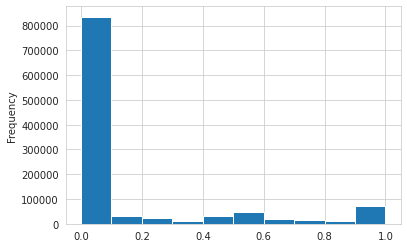

In [ ]:
pd.Series(subjectivity).plot(kind = 'hist')

## EDA Part 2

### Principal Components Analysis

### Clustering with K-Means

In [6]:
# compute normalised ratings
data = train_data.groupby('userId')['rating'].mean().reset_index().rename(columns = {'rating':'avg_rating'})
train_data = pd.merge(train_data, data, on = 'userId')
train_data['norm_rating'] = train_data['rating'].sub(train_data['avg_rating'])
train_data.head()

,userId,movieId,rating,avg_rating,norm_rating
0,5163,57669,4.0,4.136364,-0.136364
1,5163,68157,5.0,4.136364,0.863636
2,5163,1247,4.5,4.136364,0.363636
3,5163,441,4.0,4.136364,-0.136364
4,5163,2671,1.0,4.136364,-3.136364


In [7]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
from collections import Counter

In [9]:
list_of_genres = list()
for string in movies_data['genres']:
    tokens = string.split('|')
    for token in tokens:
        list_of_genres.append(token)

Counter(list_of_genres).most_common(5)

[('Drama', 25606),
 ('Comedy', 16870),
 ('Thriller', 8654),
 ('Romance', 7719),
 ('Action', 7348)]

In [10]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre)]
        avg_genre_votes_per_user = (
            ratings[ratings['movieId']
                    .isin(genre_movies['movieId'])]
                    .loc[:, ['userId', 'norm_rating']]
                    .groupby(['userId'])['norm_rating']
                    .mean()
                    .round(2))
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = [f"avg_{genre}_rating" for genre in genres]
    return genre_ratings

In [11]:
# get genre ratigs
genre_ratings = get_genre_ratings(
    train_data, movies_data, 
    ['Comedy','Thriller', 'Romance', 'Action'])
genre_ratings.head()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating
1,-0.12,1.09,-0.08,1.09
2,-0.33,0.36,-0.39,0.03
3,-0.25,-0.04,-0.17,-0.07
4,0.19,-0.11,-0.06,-0.27
5,-0.14,-0.07,-0.05,-0.74


In [12]:
genre_ratings.describe()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating
count,160040.000000,157872.000000,152414.000000,158164.000000
mean,-0.106847,-0.024439,-0.009314,-0.103786
std,0.386979,0.435191,0.505956,0.446319
min,-4.040000,-4.040000,-4.000000,-3.920000
25%,-0.260000,-0.190000,-0.220000,-0.280000
50%,-0.080000,0.000000,0.010000,-0.070000
75%,0.080000,0.180000,0.240000,0.110000
max,2.910000,3.920000,3.860000,3.370000


In [13]:
action_mask = genre_ratings['avg_Action_rating'] > 0.2
comedy_mask = genre_ratings['avg_Comedy_rating'] > 0.2
thriller_mask = genre_ratings['avg_Thriller_rating'] > 0.2
romance_mask = genre_ratings['avg_Romance_rating'] > 0.2
X = genre_ratings[action_mask | comedy_mask | thriller_mask | romance_mask].dropna()
X.head()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating
1,-0.12,1.09,-0.08,1.09
2,-0.33,0.36,-0.39,0.03
7,0.00,-1.00,0.50,-1.00
8,0.25,0.06,-0.15,0.18
9,-0.03,0.43,0.18,-0.63


In [ ]:
genre_ratings.isnull().sum() / len(genre_ratings)

avg_Comedy_rating      0.015314
avg_Thriller_rating    0.028653
avg_Romance_rating     0.062235
avg_Action_rating      0.026857
dtype: float64

In [ ]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

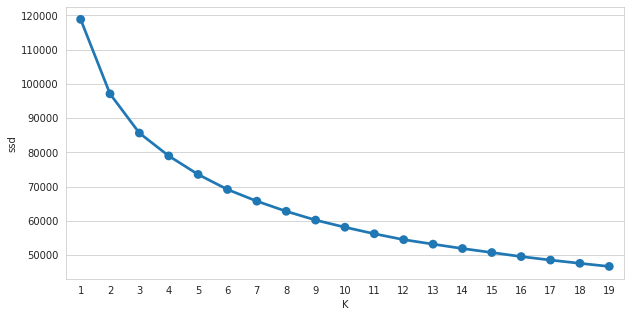

In [ ]:
rez = pd.DataFrame({'ssd':Sum_of_squared_distances, 'K':range(1, 20)})
fig = plt.figure(figsize = (10, 5))
sns.pointplot(data = rez, x = 'K', y = 'ssd')

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(5)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [15]:
X = pd.concat([X, pd.DataFrame(kmeans.predict(X) + 1, index = X.index)], axis = 1).rename(columns = {0:'km_clusters'})
X['km_clusters'] = X['km_clusters'].map(lambda x: f"clus_{x}")
X.head()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating,km_clusters
1,-0.12,1.09,-0.08,1.09,clus_3
2,-0.33,0.36,-0.39,0.03,clus_3
7,0.00,-1.00,0.50,-1.00,clus_5
8,0.25,0.06,-0.15,0.18,clus_3
9,-0.03,0.43,0.18,-0.63,clus_1


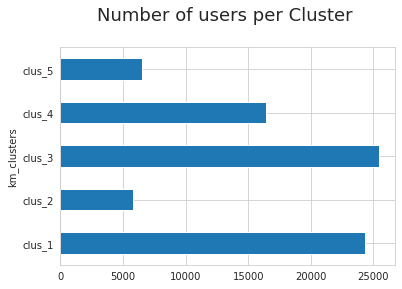

In [16]:
g = X.groupby('km_clusters').count()['avg_Romance_rating'].plot(kind = 'barh')
g.set_title('Number of users per Cluster \n', fontsize = 18)
plt.show()

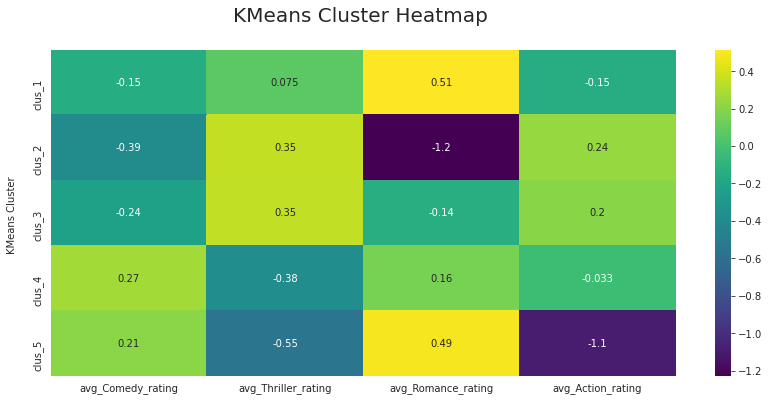

In [17]:
fig = plt.figure(figsize = (14, 6))
g = sns.heatmap(X.groupby('km_clusters').mean(), cmap = 'viridis', annot = True)
g.set_title('KMeans Cluster Heatmap \n ', fontsize = 20)
g.set_ylabel('KMeans Cluster \n')
plt.show()

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X.iloc[:, :-1])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [30]:
pca.explained_variance_

array([0.47201449, 0.23999842])

In [38]:
data = pd.DataFrame(pca.transform(X.iloc[:, :-1]), columns = ['PCA_1', 'PCA_2'])
data['km_clusters'] = X['km_clusters'].to_list()
data.head()

,PCA_1,PCA_2,km_clusters
0,1.181235,-0.783187,clus_3
1,0.603061,0.113280,clus_3
2,-1.236801,0.534809,clus_5
3,0.190707,0.183794,clus_3
4,-0.149428,0.069555,clus_1


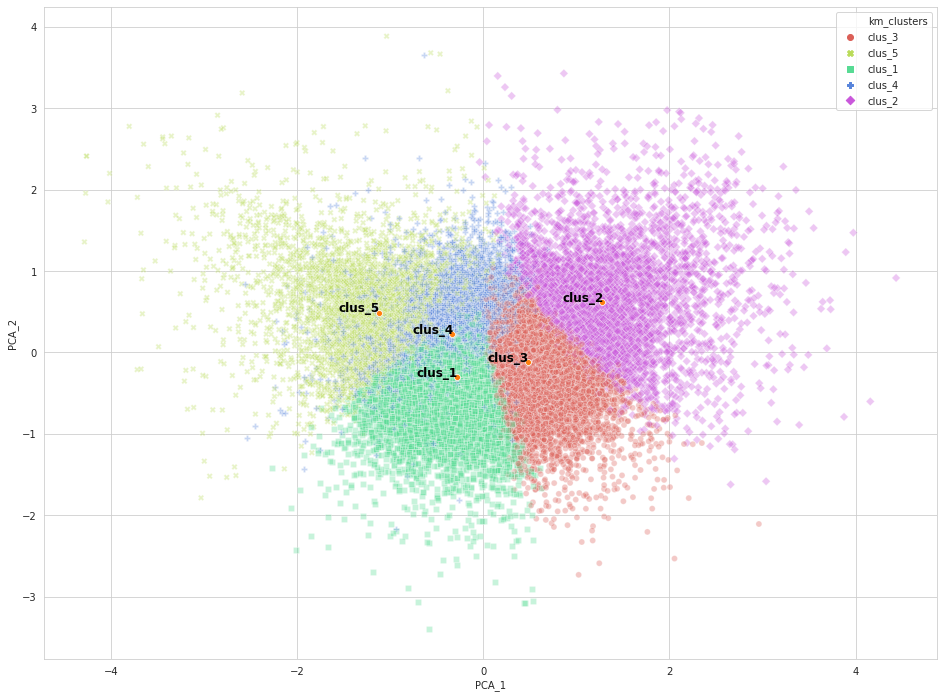

In [98]:
fig = plt.figure(figsize = (16, 12))
g = sns.scatterplot(data = data, x = 'PCA_1', y = 'PCA_2', hue = 'km_clusters', style = 'km_clusters', palette = 'hls', alpha = 1/3)

mean_data = data.groupby('km_clusters').mean().reset_index()
g = sns.scatterplot(data = mean_data, x = 'PCA_1', y = 'PCA_2', legend = False)

for line in mean_data.index:
     g.text(mean_data.PCA_1[line]+0.01, mean_data.PCA_2[line]+0.01, 
     mean_data.km_clusters[line], horizontalalignment='right', 
     size='large', color='black', weight='semibold')

In [100]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X.iloc[:, :-1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 78515 samples in 0.066s...
[t-SNE] Computed neighbors for 78515 samples in 5.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 78515
[t-SNE] Computed conditional probabilities for sample 2000 / 78515
[t-SNE] Computed conditional probabilities for sample 3000 / 78515
[t-SNE] Computed conditional probabilities for sample 4000 / 78515
[t-SNE] Computed conditional probabilities for sample 5000 / 78515
[t-SNE] Computed conditional probabilities for sample 6000 / 78515
[t-SNE] Computed conditional probabilities for sample 7000 / 78515
[t-SNE] Computed conditional probabilities for sample 8000 / 78515
[t-SNE] Computed conditional probabilities for sample 9000 / 78515
[t-SNE] Computed conditional probabilities for sample 10000 / 78515
[t-SNE] Computed conditional probabilities for sample 11000 / 78515
[t-SNE] Computed conditional probabilities for sample 12000 / 78515
[t-SNE] Computed conditional probabilities for sa

In [108]:
data = pd.DataFrame(tsne_results, columns = ['tsne_2d_1', 'tsne_2d_2'])
data['km_clusters'] = X['km_clusters'].to_list()
data.head()

,tsne_2d_1,tsne_2d_2,km_clusters
0,-1.538223,-1.701903,clus_3
1,-3.831529,-2.503504,clus_3
2,4.711242,-1.423315,clus_5
3,-1.084341,-0.297737,clus_3
4,1.081378,-1.561114,clus_1


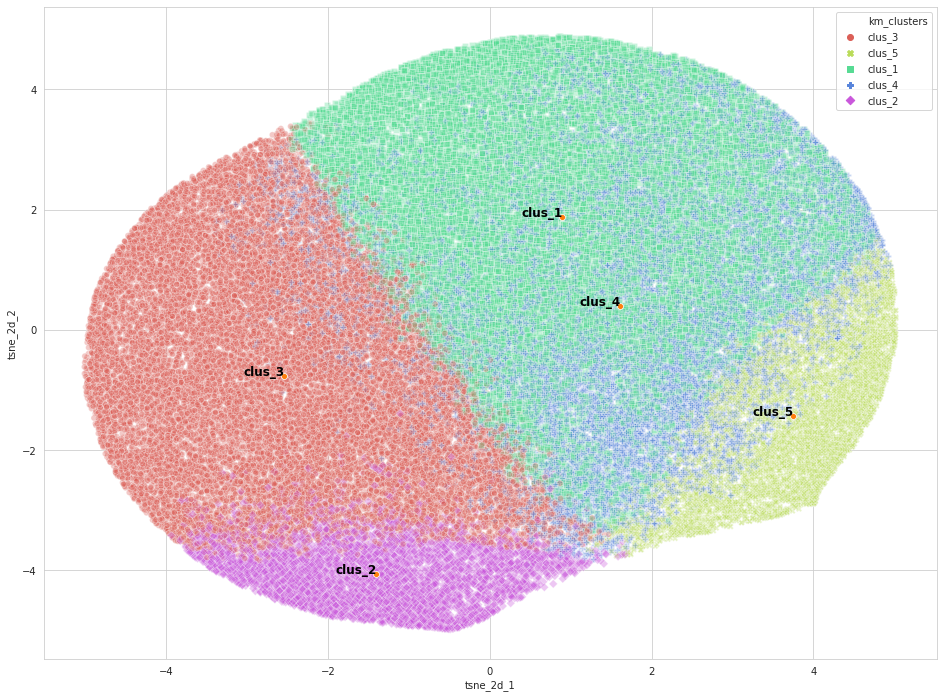

In [110]:
fig = plt.figure(figsize = (16, 12))
g = sns.scatterplot(data = data, x = 'tsne_2d_1', y = 'tsne_2d_2', hue = 'km_clusters', style = 'km_clusters', palette = 'hls', alpha = 1/3)

mean_data = data.groupby('km_clusters').mean().reset_index()
g = sns.scatterplot(data = mean_data, x = 'tsne_2d_1', y = 'tsne_2d_2', legend = False)

for line in mean_data.index:
     g.text(mean_data.tsne_2d_1[line]+0.01, mean_data.tsne_2d_2[line]+0.01, 
     mean_data.km_clusters[line], horizontalalignment='right', 
     size='large', color='black', weight='semibold')

### Hierachical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg_clus = AgglomerativeClustering(n_clusters = 5) #, linkage='average', affinity='euclidean'
agg_clus.fit(X.iloc[:, :-1])

In [ ]:
X = pd.concat([X, pd.DataFrame(agg_clus.predict(X.iloc[:, :-1]) + 1, index = X.index)], axis = 1).rename(columns = {0:'agg_clusters'})
X['agg_clusters'] = X['agg_clusters'].map(lambda x: f"clus_{x}")
X.head()

# Recommendation Systems

### Popularity Based Recommendation Engine

### Content Based Recommendation Engine

In [111]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [112]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [114]:
def getMostRelevantTags(n_most_relevant_tags = 50):
    text_data = pd.DataFrame()
    for i, movie_id in enumerate(genome_scores['movieId'].unique()):
        tags_text = {}
        mask = genome_scores['movieId'] == movie_id
        tag_ids = genome_scores[mask].sort_values('relevance', ascending = False).iloc[:n_most_relevant_tags,]['tagId'].to_list()
        tags_list = genome_tags[genome_tags['tagId'].isin(tag_ids)]['tag'].to_list()
        tags_text[movie_id] = ' '.join(tags_list)
        data = pd.DataFrame(tags_text, index = [0]).transpose().rename(columns = {0:'tags'})
        text_data = pd.concat([text_data, data])
        # print(i, movie_id)
    return text_data

In [ ]:
text_data = getMostRelevantTags(n_most_relevant_tags = 50)
text_data = text_data.reset_index().rename(columns = {'index':'movieId'})
text_data.head()

In [116]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [117]:
text_data = pd.merge(text_data, movies_data[['movieId', 'title']], how = 'left') 
text_data.head()

,movieId,tags,title
0,1,action adventure affectionate animated animati...,Toy Story (1995)
1,2,action adaptation adventure animals bad cgi ba...,Jumanji (1995)
2,3,betrayal catastrophe chase comedy crappy seque...,Grumpier Old Men (1995)
3,4,adaptation adapted from:book adultery bad acti...,Waiting to Exhale (1995)
4,5,bittersweet catastrophe chase comedy crappy se...,Father of the Bride Part II (1995)


In [118]:
text_data = text_data.drop_duplicates('title')

In [119]:
from wordcloud import WordCloud

def plotCloud(movie_title):
    text = text_data[text_data['title'] == movie_title]['tags'].iloc[0]
    word_cloud = WordCloud().generate(text)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(f"{movie_title} tags \n", fontsize = 20)
    plt.axis("off")
    plt.show()

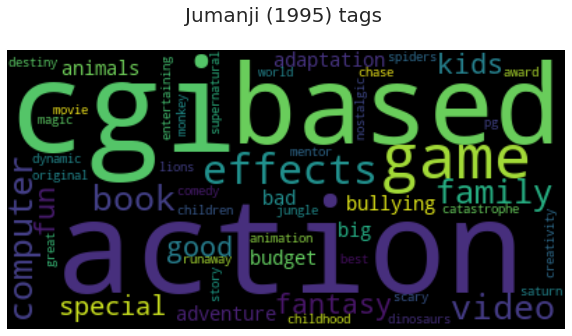

In [120]:
movie_title = 'Jumanji (1995)'
plotCloud(movie_title = movie_title)

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
text_matrix = vec.fit_transform(text_data['tags'])
text_matrix

<13813x1161 sparse matrix of type '<class 'numpy.int64'>'
	with 836743 stored elements in Compressed Sparse Row format>

In [122]:
from sklearn.metrics.pairwise import cosine_similarity
dist_matrix = cosine_similarity(text_matrix)

In [123]:
print(dist_matrix.shape)
dist_matrix = pd.DataFrame(dist_matrix, index = text_data['title'], columns = text_data['title'])
dist_matrix.head(3)

(13813, 13813)


title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),"American President, The (1995)",Dracula: Dead and Loving It (1995),Balto (1995),Nixon (1995),Cutthroat Island (1995),Casino (1995),Sense and Sensibility (1995),Four Rooms (1995),Ace Ventura: When Nature Calls (1995),Money Train (1995),Get Shorty (1995),Copycat (1995),Assassins (1995),Powder (1995),Leaving Las Vegas (1995),Othello (1995),Now and Then (1995),Persuasion (1995),"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Dangerous Minds (1995),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Wings of Courage (1995),Babe (1995),Carrington (1995),Dead Man Walking (1995),Across the Sea of Time (1995),It Takes Two (1995),Clueless (1995),"Cry, the Beloved Country (1995)",...,Wine Country (2019),The Lighthouse (2019),Long Shot (2019),Men in Black: International (2019),Toy Story 4 (2019),Brightburn (2019),Midsommar (2019),Murder Mystery (2019),Spider-Man: Far from Home (2019),Yesterday (2019),Stuber (2019),I Am Mother (2019),The Art of Self-Defense (2019),Crawl (2019),Pain and Glory (2019),Always Be My Maybe (2019),Rim of the World (2019),Once Upon a Time in Hollywood (2019),Parasite (2019),Child's Play (2019),Late Night (2019),Deadwood: The Movie (2019),Anna (2019),Scary Stories to Tell in the Dark (2019),Good Boys (2019),The Lion King (2019),Shaft (2019),Annabelle Comes Home (2019),Fast & Furious Presents: Hobbs & Shaw (2019),The Great Hack (2019),Ad Astra (2019),It: Chapter Two (2019),In the Tall Grass,Joker (2019),Ready or Not (2019),Zombieland: Double Tap (2019),Downton Abbey (2019),El Camino: A Breaking Bad Movie (2019),Dave Chappelle: Sticks & Stones (2019),Between Two Ferns: The Movie (2019)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.377671,0.400000,0.317396,0.380591,0.313928,0.376718,0.401751,0.105240,0.293259,0.384066,0.141296,0.506555,0.264996,0.296946,0.320815,0.269565,0.211597,0.189312,0.282592,0.340615,0.211171,0.150747,0.243673,0.229706,0.394752,0.400099,0.181820,0.177069,0.156386,0.289427,0.207794,0.336712,0.643088,0.152617,0.229373,0.427770,0.473702,0.336712,0.216357,...,0.227946,0.256998,0.374380,0.207223,0.580565,0.276360,0.305596,0.306420,0.340853,0.466252,0.137824,0.253045,0.254362,0.304695,0.244187,0.393625,0.285081,0.378560,0.357776,0.157372,0.317303,0.417391,0.235418,0.241331,0.249296,0.395773,0.269390,0.142022,0.216254,0.203235,0.344049,0.352987,0.119242,0.402334,0.277591,0.389463,0.316942,0.358245,0.320827,0.229366
Jumanji (1995),0.377671,1.000000,0.262728,0.345084,0.233992,0.183073,0.355689,0.453540,0.397462,0.350726,0.252996,0.124515,0.371078,0.217919,0.404063,0.167396,0.246307,0.118055,0.127675,0.302393,0.197908,0.089722,0.223665,0.300861,0.086753,0.223630,0.268633,0.261593,0.135837,0.068906,0.377757,0.057223,0.317916,0.421660,0.230556,0.209101,0.284559,0.323021,0.249177,0.306419,...,0.215221,0.074662,0.222188,0.303266,0.337328,0.309255,0.133964,0.335979,0.402283,0.342398,0.199533,0.230070,0.163311,0.505630,0.144098,0.265466,0.249229,0.095895,0.100428,0.138682,0.396232,0.361251,0.202948,0.294319,0.174355,0.454476,0.381529,0.321826,0.252797,0.141393,0.137812,0.343382,0.235406,0.198571,0.196572,0.342068,0.157500,0.183620,0.128511,0.196875
Grumpier Old Men (1995),0.400000,0.262728,1.000000,0.500139,0.716926,0.378560,0.615612,0.471620,0.229615,0.391012,0.598429,0.348530,0.358082,0.247899,0.393017,0.396798,0.243478,0.413576,0.504832,0.499245,0.445419,0.274522,0.226120,0.393625,0.174577,0.438613,0.551247,0.138529,0.077468,0.156386,0.425628,0.173162,0.382213,0.464452,0.193315,0.150279,0.447214,0.640376,0.409514,0.333550,...,0.383363,0.217460,0.599008,0.362641,0.535907,0.409423,0.349253,0.622725,0.350322,0.652753,0.312400,0.328021,0.437502,0.461659,0.315408,0.543578,0.327315,0

In [124]:
def getRecommendations(neighbors = 10):
    similarity_data = pd.DataFrame()
    for i, movie_title in enumerate(dist_matrix.index):
        sim_data = dist_matrix.loc[movie_title].reset_index()
        sim_data['movie'] = movie_title
        sim_data = sim_data.rename(columns = {movie_title:'similarity', 'title':'recommendations', 'movie':'title'}).sort_values(by = 'similarity', ascending = False)[1:].iloc[:10]
        sim_data['rank'] = range(1, len(sim_data) + 1)
        similarity_data = pd.concat([similarity_data, sim_data])
    return similarity_data

In [125]:
similarity_data = getRecommendations(neighbors = 10)
similarity_data

,recommendations,similarity,title,rank
2807,Toy Story 2 (1999),0.880217,Toy Story (1995),1
4407,"Monsters, Inc. (2001)",0.880191,Toy Story (1995),2
8809,Ratatouille (2007),0.831177,Toy Story (1995),3
2094,"Bug's Life, A (1998)",0.798600,Toy Story (1995),4
10284,Toy Story 3 (2010),0.797207,Toy Story (1995),5
...,...,...,...,...
13473,Game Night (2018),0.566635,Between Two Ferns: The Movie (2019),6
11896,Stretch (2014),0.563369,Between Two Ferns: The Movie (2019),7
12322,Comedy Central Roast of James Franco (2013),0.559133,Between Two Ferns: The Movie (2019),8
8878,"Darwin Awards, The (2006)",0.553399,Between Two Ferns: The Movie (2019),9


In [126]:
movie_title = 'Jumanji (1995)'
sim_data = similarity_data[similarity_data['title'] == movie_title]
sim_data

,recommendations,similarity,title,rank
459,Jurassic Park (1993),0.687046,Jumanji (1995),1
9593,Dinotopia (2002),0.650651,Jumanji (1995),2
9419,Journey to the Center of the Earth (2008),0.648610,Jumanji (1995),3
3580,How the Grinch Stole Christmas (a.k.a. The Gri...,0.643653,Jumanji (1995),4
9243,"Spiderwick Chronicles, The (2008)",0.643182,Jumanji (1995),5
1381,"Lost World: Jurassic Park, The (1997)",0.639390,Jumanji (1995),6
10264,Prince of Persia: The Sands of Time (2010),0.630521,Jumanji (1995),7
8309,"Chronicles of Narnia: The Lion, the Witch and ...",0.610483,Jumanji (1995),8
2168,Mighty Joe Young (1998),0.601462,Jumanji (1995),9
5783,Lara Croft Tomb Raider: The Cradle of Life (2003),0.599592,Jumanji (1995),10


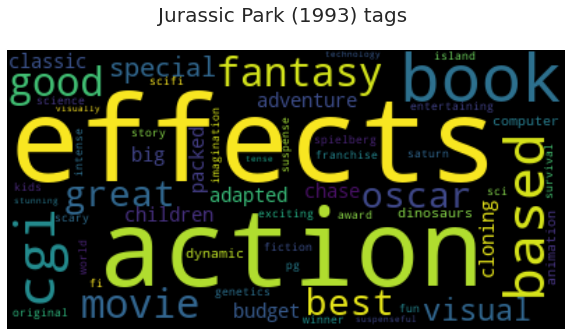

In [127]:
movie_title = sim_data['recommendations'].iloc[0]
plotCloud(movie_title = movie_title)

In [128]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(text_matrix.toarray())

In [129]:
pca.explained_variance_

array([6.12645063, 4.76354058])

In [130]:
pca_rez = pd.DataFrame(principal_components)
pca_rez['title'] = text_data['title']
pca_rez.columns = ['PCA_1', 'PCA_2', 'title']
pca_rez.tail()

,PCA_1,PCA_2,title
13808,-0.528671,2.878677,In the Tall Grass
13809,4.214394,1.437420,Joker (2019)
13810,-0.168852,1.066980,Ready or Not (2019)
13811,0.500290,0.368970,Zombieland: Double Tap (2019)
13812,-1.834999,-0.028582,Downton Abbey (2019)


In [132]:
movies = list()
for movie in ['Joker (2019)']:
    similar_movies = similarity_data[similarity_data['title'] == movie]['recommendations'][:5].tolist()
    for similar_movie in similar_movies:
        movies.append(similar_movie)
movies

['Cosmos: A Spacetime Odissey',
 'Three Billboards Outside Ebbing, Missouri (2017)',
 'Black Mirror',
 'BlacKkKlansman (2018)',
 'Whiplash (2013)']

In [133]:
indz = list()
for i, movie in enumerate(pca_rez['title']):
    if movie in movies:
        indz.append(i)
indz

[13070, 13343, 13366, 13454, 13598]

In [134]:
pca_rez['indicator'] = np.where(pca_rez['title'].isin(movies), 'Yes', 'No')
pca_rez.head()

,PCA_1,PCA_2,title,indicator
0,0.705889,3.160370,Toy Story (1995),No
1,-1.499707,2.161670,Jumanji (1995),No
2,-2.174973,4.040107,Grumpier Old Men (1995),No
3,-0.503611,3.336355,Waiting to Exhale (1995),No
4,-2.112427,3.296409,Father of the Bride Part II (1995),No


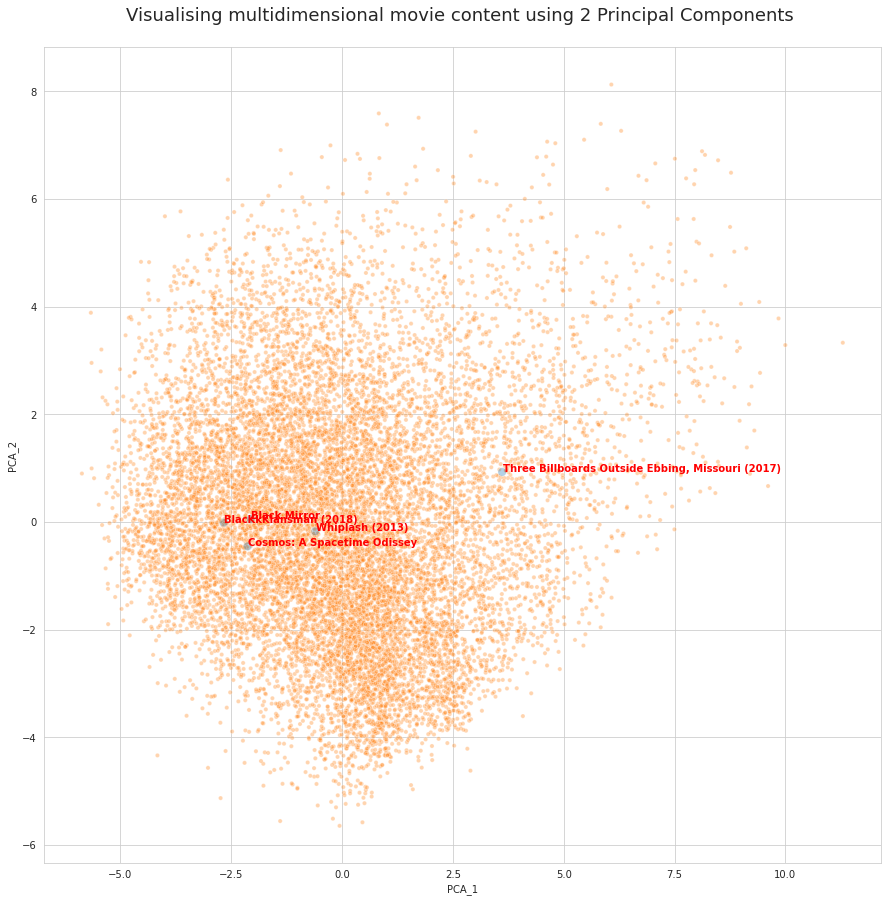

In [137]:
fig = plt.figure(figsize = (15, 15))
g = sns.scatterplot(data = pca_rez, x = 'PCA_1', y = 'PCA_2', alpha = 1/3, legend = False,
                    hue = 'indicator', hue_order = ['Yes', 'No'], size = 'indicator', size_order = ['Yes', 'No'])
g.set_title('Visualising multidimensional movie content using 2 Principal Components \n', fontsize = 18)

for line in indz:
     g.text(pca_rez.PCA_1[line]+0.01, pca_rez.PCA_2[line]+0.01, 
     pca_rez.title[line], horizontalalignment='left', 
     size='medium', color='red', weight='semibold')

In [138]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(text_matrix.toarray())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13813 samples in 2.128s...
[t-SNE] Computed neighbors for 13813 samples in 416.297s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13813
[t-SNE] Computed conditional probabilities for sample 2000 / 13813
[t-SNE] Computed conditional probabilities for sample 3000 / 13813
[t-SNE] Computed conditional probabilities for sample 4000 / 13813
[t-SNE] Computed conditional probabilities for sample 5000 / 13813
[t-SNE] Computed conditional probabilities for sample 6000 / 13813
[t-SNE] Computed conditional probabilities for sample 7000 / 13813
[t-SNE] Computed conditional probabilities for sample 8000 / 13813
[t-SNE] Computed conditional probabilities for sample 9000 / 13813
[t-SNE] Computed conditional probabilities for sample 10000 / 13813
[t-SNE] Computed conditional probabilities for sample 11000 / 13813
[t-SNE] Computed conditional probabilities for sample 12000 / 13813
[t-SNE] Computed conditional probabilities for 

In [143]:
tsne_rez = pd.DataFrame(tsne_results)
tsne_rez['title'] = text_data['title']
tsne_rez.columns = ['TSNE_1', 'TSNE_2', 'title']
tsne_rez.tail()

,TSNE_1,TSNE_2,title
13808,3.439597,0.866611,In the Tall Grass
13809,-2.124937,5.451530,Joker (2019)
13810,-0.345454,-0.387326,Ready or Not (2019)
13811,0.208425,1.029100,Zombieland: Double Tap (2019)
13812,1.537529,-0.743662,Downton Abbey (2019)


In [144]:
tsne_rez['indicator'] = np.where(tsne_rez['title'].isin(movies), 'Yes', 'No')
tsne_rez.head()

,TSNE_1,TSNE_2,title,indicator
0,8.259012,0.358493,Toy Story (1995),No
1,5.295952,-4.884237,Jumanji (1995),No
2,4.156676,0.946059,Grumpier Old Men (1995),No
3,4.176154,3.666785,Waiting to Exhale (1995),No
4,5.956745,2.305066,Father of the Bride Part II (1995),No


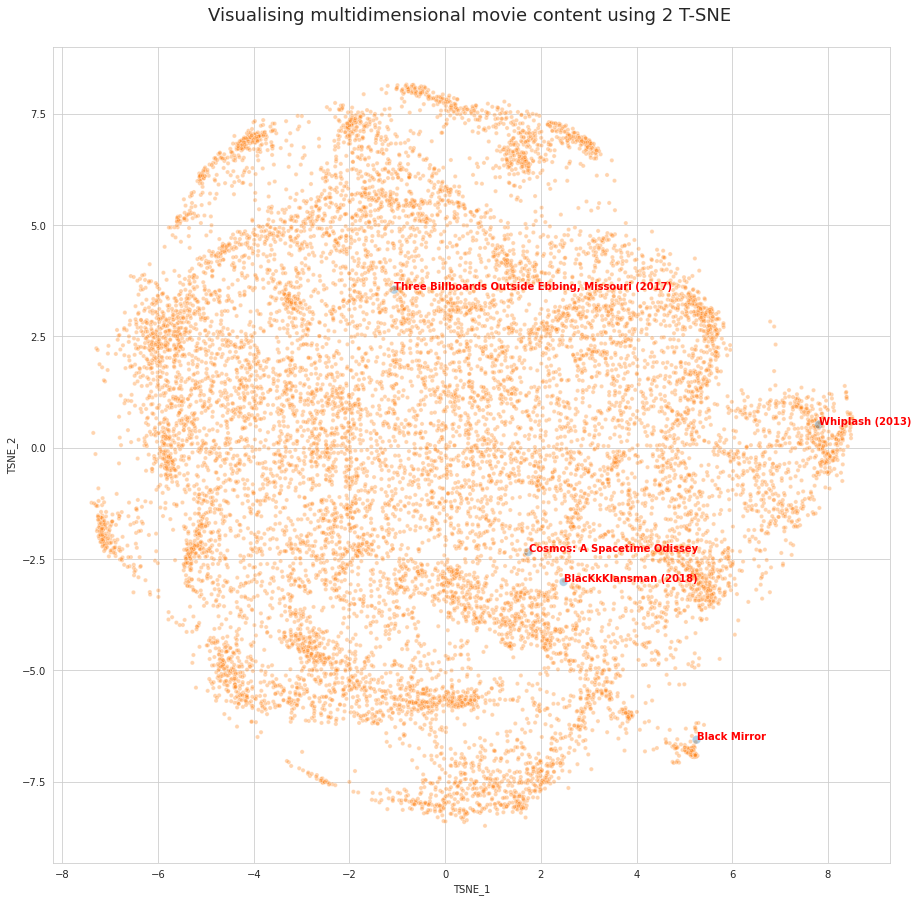

In [145]:
fig = plt.figure(figsize = (15, 15))
g = sns.scatterplot(data = tsne_rez, x = 'TSNE_1', y = 'TSNE_2', alpha = 1/3, legend = False,
                    hue = 'indicator', hue_order = ['Yes', 'No'], size = 'indicator', size_order = ['Yes', 'No'])
g.set_title('Visualising multidimensional movie content using 2 T-SNE \n', fontsize = 18)

for line in indz:
     g.text(tsne_rez.TSNE_1[line]+0.01, tsne_rez.TSNE_2[line]+0.01, 
     tsne_rez.title[line], horizontalalignment='left', 
     size='medium', color='red', weight='semibold')

### Collaboration Filtering Engines

#### Memory Based Filters

##### Item-Item Recommender

##### User-User Recommender

#### Model Based Filters

##### Matrix Factorisation

### Model Perfomance Evaluation and Selection

# Summary of Conclusions